# Processus CMJ (Crump - Mode - Jagers) : exemples

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Exemple : processus de Poisson avec birth rate et type dépendant de l'âge

$b$ une fonction définie sur $\mathbb{R}_+$ : $\textit{birth rate}$

$\mathbb{S}$ représente l'ensemble des longueurs de télomères (à la naissance). L'unité utilisée est le millier de paires de bases (kpb). On suppose que les longueurs de télomères à la naissance sont comprises entre 5 kpb et 15 kpb. 

Semi-groupe markovien $p_t$ de $\mathbb{S}$ vers $\mathbb{S}$ :
$$ p_t(s_0, \bullet) \sim \mathcal{N}(s_0 + \alpha t -  m, \sigma) $$ (loi tronquée au segment $[5,15]$)

On impose $\alpha = 0.01$ (vitesse de croissance des télomères des gamètes du père : environ 20 pb/an) et on fixe $m = 35\times \alpha$ de telle sorte que la moyenne de la gaussienne soit égale à 10kpb pour $s_0 = 10$ et $t = 35$.

$\xi$ : mesure aléatoire de Poisson sur $\mathbb{S}\times \mathbb{R}_{+}$ d'intensité $b(t)p_t(s_0, \mathrm{d}s)\mathrm{d}t$

In [21]:
### Paramètres du modèle ###

## Paramètres pour le birth rate ##
a1 = 0.005
a2 = 0.005

## Paramètres pour le noyau de transition ##
alpha = 0.01
m = alpha * 35
sigma = 0.1

## Paramètres de simulation
T_max = 200 # Durée de simulation (années)

def b(t):
    '''
    Birth rate
    t : âge
    '''
    if t < 15 or t > 55: return 0
    if t < 35: return a1*(t-15)
    return 20*a1 - a2*(t-35)

def p(t, s0):
    '''
    Semi-groupe de transition: simulation du type du descendant
    t : âge du parent à la reproduction
    s0 : type de départ
    '''
    x = s0 + alpha * t - m + sigma * np.random.randn()
    return min(max(x,5),15)

def random_poisson_measure_inhomogeneous(t0, T, birth_rate, sup_birth_rate, s0 = 10):
    '''
    Simulation des points pour le processus de Poisson:
    - t0 : date de naissance du parent
    - T : date de fin (pour la simulation)
    - birth_rate : fonction birth rate
    - sup_birth_rate : norme sup de la fonction birth rate (utile pour l'algo de rejet)
    - s0 : type du parent (défaut : 10)
    '''
    jump_times = list((T-t0) * np.random.rand(np.random.poisson(sup_birth_rate * T)) + t0)
    i = 0
    while i < len(jump_times):
        if np.random.rand() >= b(jump_times[i]-t0)/sup_birth_rate:
            del jump_times[i]
        else:
            i += 1
    jump_times.sort()
    types = [p(t-t0, s0) for t in jump_times]
    return jump_times, types

def iteration_inhomogeneous(population, T_max, unexplored, birth_rate, sup_birth_rate, s0 = 10):
    '''
    Itération dans la simulation du processus (simulation d'une descendance)
    - population : dictionnaire des individus simulés
    - T_max : temps de fin de simulation
    - unexplored : indices des individus dont les descendances n'ont pas encore été simulées
    - birth_rate : fonction birth rate
    - sup_birth_rate : norme sup de la fonction birth rate
    - s0 : type du parent (défaut : 10)
    '''
    ind = unexplored.pop(0)
    t0, s0 = population[ind]
    jump_times, types = random_poisson_measure_inhomogeneous(0, T_max - t0, birth_rate, sup_birth_rate,  s0 = s0)
    for i in range(len(jump_times)):
        new_ind = ind + chr(i+1)
        population[new_ind] = (t0 + jump_times[i], types[i])
        unexplored.append(new_ind)
    return

def simul_population_inhomogeneous(T, birth_rate, sup_birth_rate, s0, verbose = False):
    '''
    Simulation du processus Jagers
    - T : durée de simulation
    - birth_rate : fonction birth rate
    - sup_birth_rate : norme sup de la fonction birth rate
    - s0 : type du parent (défaut : 10)
    '''
    n_it = 0
    population = {chr(0): (0,s0)}
    unexplored = list(population.keys())
    while len(unexplored) >= 1:
        iteration_inhomogeneous(population, T, unexplored, birth_rate, sup_birth_rate, s0 = s0)
        n_it += 1
        if n_it % 1000 == 0 and verbose:
            print("{} itérations".format(n_it))
    print("{} itérations au total".format(n_it))
    return population

In [22]:
# Plot populations

# Simple scatter plot
def scatter_plot_population(pop):
    '''
    Plot simple d'une population après simulation
    - pop : dictionnaire des individus (avec type et date de naissance)
    '''
    times, types = [pop[key][0] for key in pop], [pop[key][1] for key in pop]
    plt.figure(figsize=(10,10))
    plt.scatter(times, types)
    plt.xlabel("Time (birth)")
    plt.ylabel("LTL (kpb)")
    plt.title("Plot simple de la population")
    plt.show()

# Scatter plot with parent-children relations
def plot_population(pop, T_max = 200):
    '''
    Plot de la population avec liens parent-enfants
    - pop : dictionnaire des individus (avec type et date de naissance)
    - T_max : temps de fin de simulation
    '''
    times, types = [pop[key][0] for key in pop], [pop[key][1] for key in pop]
    plt.figure(figsize=(10,10))
    plt.scatter(times, types, color = 'r')
    plt.hlines(y = pop[chr(0)][1], xmin=0, xmax=T_max, color = 'b')
    for key in pop.keys():
        i = 1
        while key + chr(i) in pop.keys():
            plt.plot([pop[key + chr(i)][0], pop[key + chr(i)][0]], [pop[key][1], pop[key + chr(i)][1]], color = 'b')
            plt.hlines(y = pop[key + chr(i)][1], xmin=pop[key + chr(i)][0], xmax=T_max, color = 'b')
            i += 1
    plt.xlabel("Time (birth)")
    plt.ylabel("LTL (kpb)")
    plt.title("Plot avec relations de parenté")
    plt.show()

In [23]:
# Birth rate
# plt.figure(figsize=(7,5))
# x = np.linspace(0,100,101)
# y = [b(e) for e in x]
# plt.plot(x,y)
# plt.xlabel('âge')
# plt.ylabel("Nombre d'enfants / an moyen (par femme)")
# plt.title("Birth rate")
# plt.show()

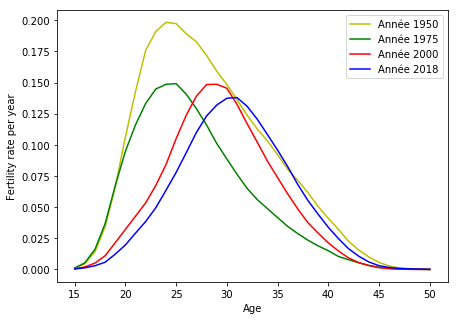

In [24]:
df = pd.read_csv("fm_fecondite_age_mere.csv", index_col = 0, 
                 names = range(14,51),
                 engine = 'python', skiprows = 5, skipfooter = 4)
del df[14]
def plot_birth_rate(year, color = 'b'):
    birth_rates = np.array(df[df.index == year] / 10000)[0]
    plt.plot(df.columns, birth_rates, color = color, label = "Année {}".format(year))

plt.figure(figsize=(7,5))
plot_birth_rate(1950, 'y')
plot_birth_rate(1975, 'g')
plot_birth_rate(2000, 'r')
plot_birth_rate(2018, 'b')
plt.xlabel('Age')
plt.ylabel('Fertility rate per year')
plt.legend()
plt.savefig('fertility_rate.png')
plt.show()

In [25]:
birth_rates = np.array(df[df.index == 2000] / 10000)[0]
def birth_rate(t):
    n = int(t)-15
    if n < 0 or n > 35:
        return 0
    else:
        if n+1 == 36:
            return birth_rates[n]*(n+1-t-15)
        return birth_rates[n] + (birth_rates[n+1] - birth_rates[n])*(t-n-15)

In [26]:
# Probabilité d'extinction dès la première génération
s = np.sum(birth_rates)
print(np.exp(-s))

0.1534623529024551


In [27]:
# Simulation d'une population
# Remarque : ne pas hésiter à relancer si le nombre d'itération est trop faible : cela signifie probablement que la population s'est éteinte
pop2 = simul_population_inhomogeneous(300, birth_rate, 0.15, 10)

961 itérations au total


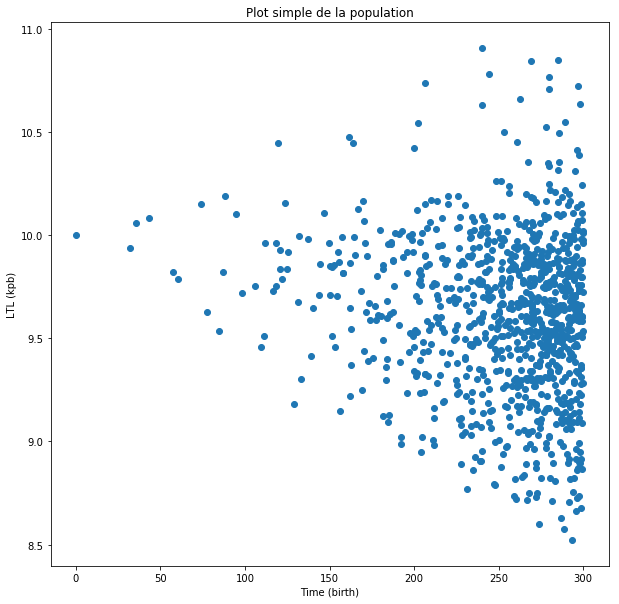

In [28]:
# Plot simple
scatter_plot_population(pop2)

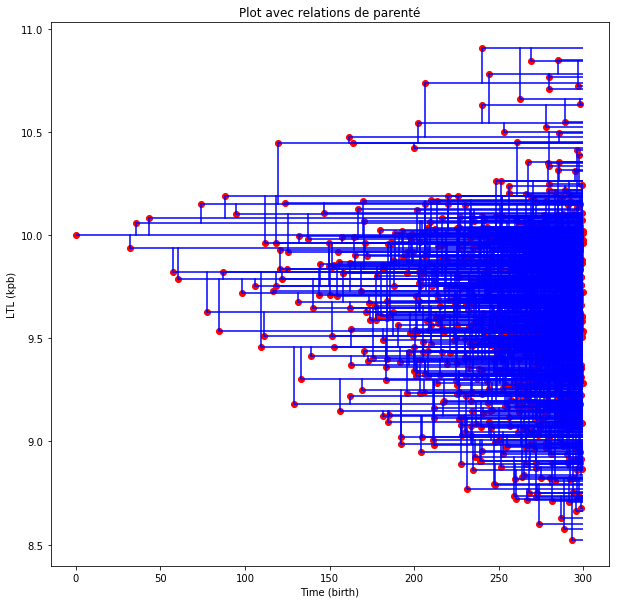

In [29]:
plot_population(pop2, T_max = 300)

In [30]:
pop3 = simul_population_inhomogeneous(550, b, 0.1, 10)
sub_pop1 = [pop3[key][1] for key in pop3.keys() if pop3[key][0]>=450]
sub_pop2 = [pop3[key][1] for key in pop3.keys() if pop3[key][0]<450 and pop3[key][0]>=350]

158654 itérations au total


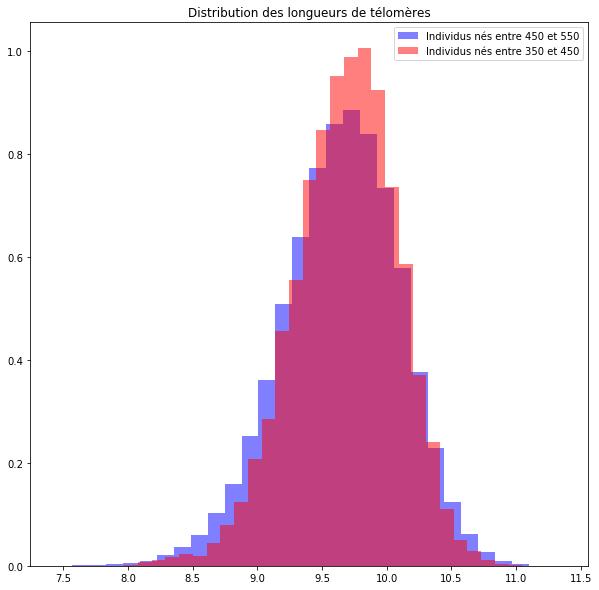

In [31]:
plt.figure(figsize = (10,10))
plt.hist(sub_pop1, bins = 30, density = True, color = 'b', alpha = 0.5, label = "Individus nés entre 450 et 550")
plt.hist(sub_pop2, bins = 30, density = True, color = 'r', alpha = 0.5, label = "Individus nés entre 350 et 450")
plt.legend()
plt.title("Distribution des longueurs de télomères")
plt.show()